In [2]:
! conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::requests==2.22.0=py37_1
  - defaults/noarch::numpydoc==0.9.2=py_0
  - defaults/linux-64::nb_conda==2.2.1=py37_0
  - defaults/linux-64::s3transfer==0.2.1=py37_0
  - defaults/noarch::ipywidgets==7.5.1=py_0
  - defaults/noarch::s3fs==0.4.2=py_0
  - defaults/linux-64::notebook==6.0.3=py37_0
  - defaults/linux-64::anaconda-client==1.7.2=py37_0
  - defaults/linux-64::widgetsnbextension==3.5.1=py37_0
  - defaults/linux-64::nb_conda_kernels==2.2.4=py37_0
  - defaults/noarch::sphinx==2.4.0=py_0
  - defaults/linux-64::jupyter==1.0.0=py37_7
  - defaults/noarch::botocore==1.12.189=py_0
  - defaults/noarch::jupyterlab_server==1.0.6=py_0
  - defaults/noarch::jupyterlab==1.2.6=pyhf63ae98_0
  - defaults/linux-64::nbconvert==5.6.1=py37_0
  - fastai/noarch::fastprogress==1.0.0=pyh39e3cac_0
  - defaults/linux-64::python-language-ser

## demo inference on DMD dataset


Ground truth:  reach_side

Top 5 predictions:

  reach_backseat: 51.22%
      safe_drive: 22.03%
   texting_right: 10.41%
talking_to_passenger: 9.93%
        drinking: 2.71%

Ground truth:  phonecall_right

Top 5 predictions:

      safe_drive: 59.38%
  reach_backseat: 21.18%
talking_to_passenger: 8.56%
   texting_right: 4.72%
 phonecall_right: 3.80%

Ground truth:  safe_drive

Top 5 predictions:

  reach_backseat: 88.43%
        drinking: 4.20%
talking_to_passenger: 3.48%
      safe_drive: 2.21%
 phonecall_right: 0.59%

Ground truth:  safe_drive

Top 5 predictions:

      safe_drive: 49.85%
talking_to_passenger: 34.28%
  reach_backseat: 13.84%
        drinking: 0.73%
   texting_right: 0.51%

Ground truth:  safe_drive

Top 5 predictions:

  reach_backseat: 90.87%
      safe_drive: 4.74%
talking_to_passenger: 2.46%
        drinking: 0.57%
           radio: 0.40%


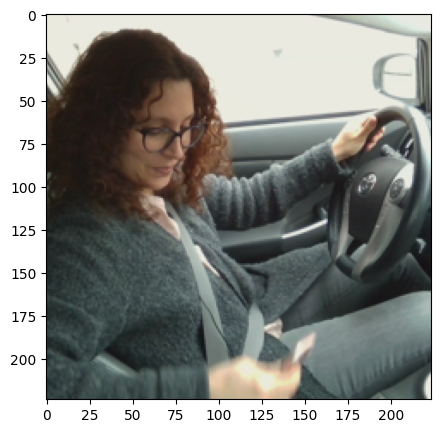

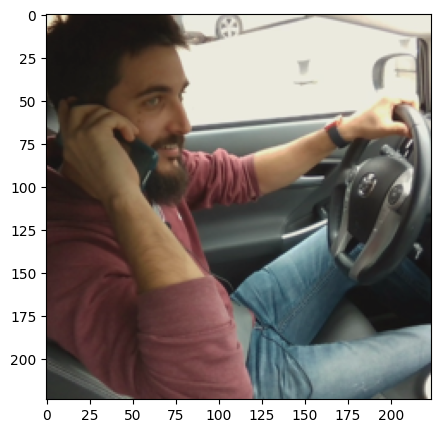

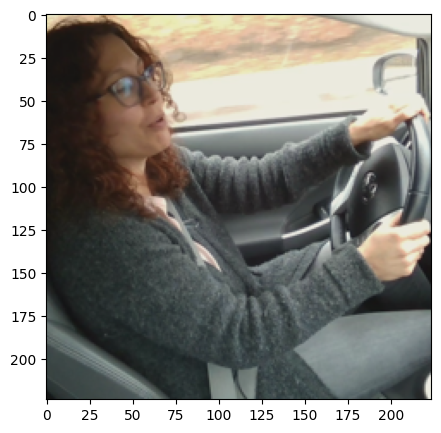

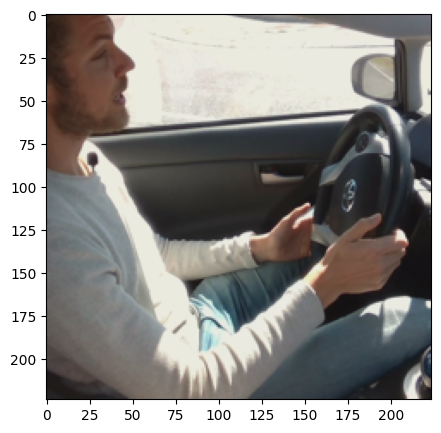

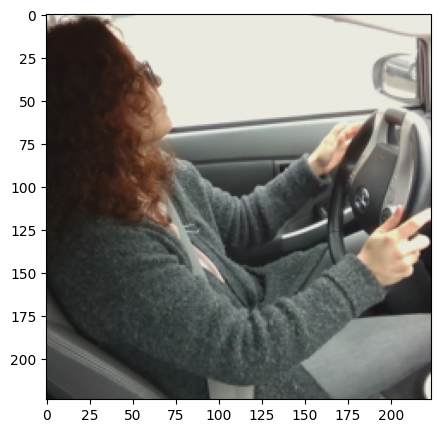

In [3]:
import os
import clip
import torch
import os
import clip
import torch
from torchvision import transforms, datasets
from PIL import Image
from torch.utils.data import Dataset
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import torchvision
import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from tqdm import tqdm


# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-L/14', device)
df=[]

# Load the dataset
data_dir = 'dmd/DMD-Driver/data/frame/dmd_rgb/driver_actions'
image_datasets = datasets.ImageFolder(data_dir, transform=preprocess)

train, val = torch.utils.data.random_split(image_datasets, [80000, 7652])
class_names = image_datasets.classes

for i in range(5000,5005):
    # Prepare the inputs
    image, class_id = train[i]


    def imshow(inp, title=None):
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        figure(figsize=(5,5))
        plt.imshow(inp)
        
    imshow(image) 
    print("\nGround truth: ", class_names[class_id])



    image_input = image.unsqueeze(0).to(device)
    text_inputs = torch.cat([clip.tokenize(f"a photo of a{c}") for c in class_names]).to(device)

    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    # Pick the top 5 most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(5)

    # Print the result
    print("\nTop 5 predictions:\n")
    for value, index in zip(values, indices):
        print(f"{class_names[index]:>16s}: {100 * value.item():.2f}%")

# DMD dataset

In [1]:
# Run zero-shotCLIP model on a smaller subset of DMD dataset (fold2/test data with 10 cls)
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import clip
import os
import numpy as np
from torch.utils.data import Subset


# Load CLIP model 
model_list= ['ViT-L/14', 'ViT-L/14@336px', 'ViT-B/16', 'ViT-B/32']

for model_ in model_list:
    print(f"Running zero-shot on {model_}:")
    model, preprocess = clip.load(f"{model_}", device='cuda')

    class CustomImageFolder(ImageFolder):
        def __getitem__(self, index):
            img, label = super().__getitem__(index)
            path = self.imgs[index][0]
            return img, label, path    

    val_data_dir = f'../dmd/DMD-Driver/data/new/fold2/test'
    val_dataset = CustomImageFolder(val_data_dir, transform=preprocess)
    print(f"Number of samples in the dataset: {len(val_dataset)}")
    subset_percentage = 1.0
    subset_size = int(len(val_dataset) * subset_percentage)
    subset_indices = np.random.choice(len(val_dataset), subset_size, replace=False)
    image_datasets = Subset(val_dataset, subset_indices)
    print("Subset size:", len(image_datasets))

    val_loader = DataLoader(image_datasets, batch_size=512, shuffle=False, num_workers=2)

    # Assume class_names are defined as per your dataset classes
    class_names = {
        0: "drinking water while driving",
        1: "adjusting hairs and makeup with hand while driving",
        2: "talking to the phone on right hand while driving",
        3: "adjusting radio with hand while driving",
        4: "reaching to the backseat while driving",
        5: "reaching side while driving",
        6: "driving safely",
        7: "talking to the passenger while driving",
        8: "texting on the phone with right hand while driving",
        9: "yawning while driving"}
    
    # templates = ["an image of a person {}.", "an image of a driver {}.","a photo of a person {}."]
    templates = ["an image of a person {}."]
    # Function for zero-shot prediction
    def zeroshot_classifier(classnames, templates):
        with torch.no_grad():
            zeroshot_weights = []
            for label, classname in classnames.items():
                texts = [template.format(classname) for template in templates]
                texts = clip.tokenize(texts).cuda()
                class_embeddings = model.encode_text(texts)
                class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
                # class_embedding = class_embeddings.mean(dim=0) 
                # class_embedding /= class_embedding.norm()
                class_embedding = class_embeddings
                zeroshot_weights.append(class_embedding)
            zeroshot_weights = torch.stack(zeroshot_weights, dim=2).cuda()
        return zeroshot_weights

    zeroshot_weights = zeroshot_classifier(class_names, templates)

    print(zeroshot_weights.shape)
    # Perform zero-shot prediction
    def accuracy(output, target, topk=(1,)):
        pred = output.topk(max(topk), 1, True, True)[1].t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]

    with torch.no_grad():
        top1, top3, n = 0., 0., 0.
        for images, target, _ in tqdm(val_loader):
            images = images.cuda()
            target = target.cuda()

            # Predict
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            logits = image_features @ zeroshot_weights
            logits = logits.squeeze(0)  # Removing the first singleton dimension

            # Measure accuracy
            acc1, acc3 = accuracy(logits, target, topk=(1, 3))
            top1 += acc1
            top3 += acc3
            n += images.size(0)

    # Calculate and print the top-1 and top-5 accuracy
    top1 = (top1 / n) * 100
    top3 = (top3 / n) * 100
    print(f"Top-1 accuracy_{model_}: {top1:.2f}%")
    print(f"Top-3 accuracy_{model_}: {top3:.2f}%")

Running zero-shot on ViT-L/14:
Number of samples in the dataset: 16210
Subset size: 16210
torch.Size([1, 768, 10])


  0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_1026936/1343060393.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]
100%|██████████| 32/32 [02:46<00:00,  5.20s/it]


Top-1 accuracy_ViT-L/14: 47.97%
Top-3 accuracy_ViT-L/14: 79.56%
Running zero-shot on ViT-L/14@336px:
Number of samples in the dataset: 16210
Subset size: 16210
torch.Size([1, 768, 10])


100%|██████████| 32/32 [03:26<00:00,  6.45s/it]


Top-1 accuracy_ViT-L/14@336px: 48.12%
Top-3 accuracy_ViT-L/14@336px: 77.16%
Running zero-shot on ViT-B/16:
Number of samples in the dataset: 16210
Subset size: 16210
torch.Size([1, 512, 10])


100%|██████████| 32/32 [02:40<00:00,  5.01s/it]


Top-1 accuracy_ViT-B/16: 31.29%
Top-3 accuracy_ViT-B/16: 54.95%
Running zero-shot on ViT-B/32:
Number of samples in the dataset: 16210
Subset size: 16210
torch.Size([1, 512, 10])


100%|██████████| 32/32 [02:49<00:00,  5.28s/it]

Top-1 accuracy_ViT-B/32: 28.39%
Top-3 accuracy_ViT-B/32: 47.76%


: 